In [1]:
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
# Extract data from text files
result_filenames = ['nist_results.txt', 'local_results.txt', 'cloud_results.txt']
data = {file : {} for file in result_filenames}
UpdateValues = namedtuple('UpdateValues', ['delay_usec', 'offset_usec'])       

for result_filename in result_filenames:
    with open(result_filename, 'r') as f:
        # Read through the data (bursts seperated by whitespace)
        update_values, burst = [], []
        for line in f.readlines()[2:]:
            if line.isspace():
                update_values.append(burst)
                burst = []
            else:
                vals = line.rstrip().split()
                vals = UpdateValues(delay_usec=int(vals[0]), offset_usec=int(vals[1]))
                burst.append(vals)
    
    data[result_filename]['vi'] = update_values
    
# Compute theta naught and delta naught for each burst
for f in result_filenames:
    data[f]['v0'] = [min(uvals, key=lambda x: x.delay_usec) for uvals in data[f]['vi']]

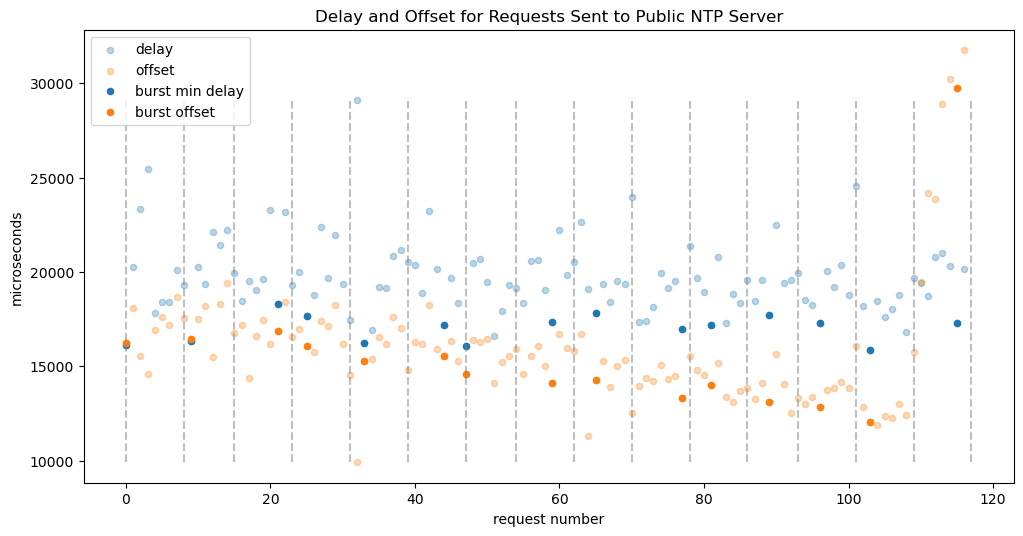

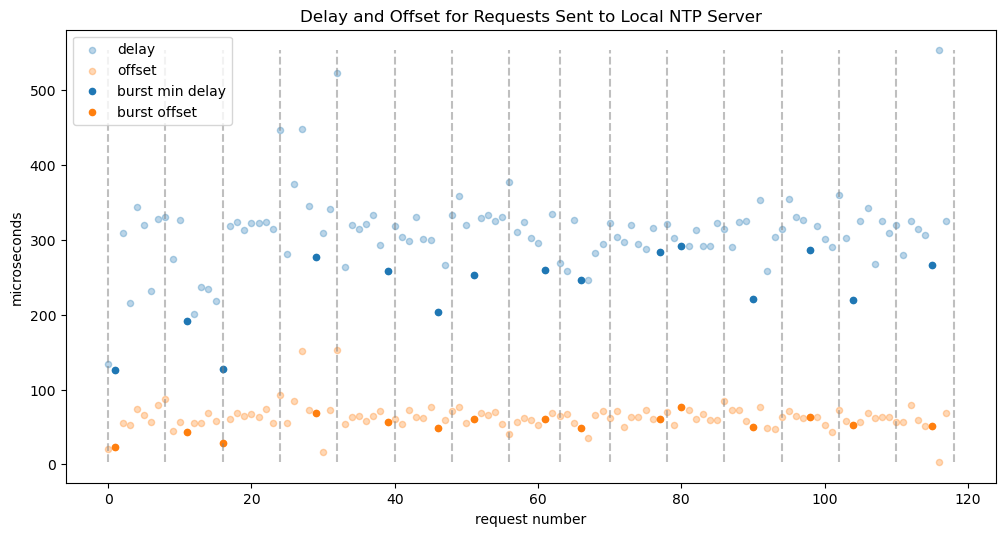

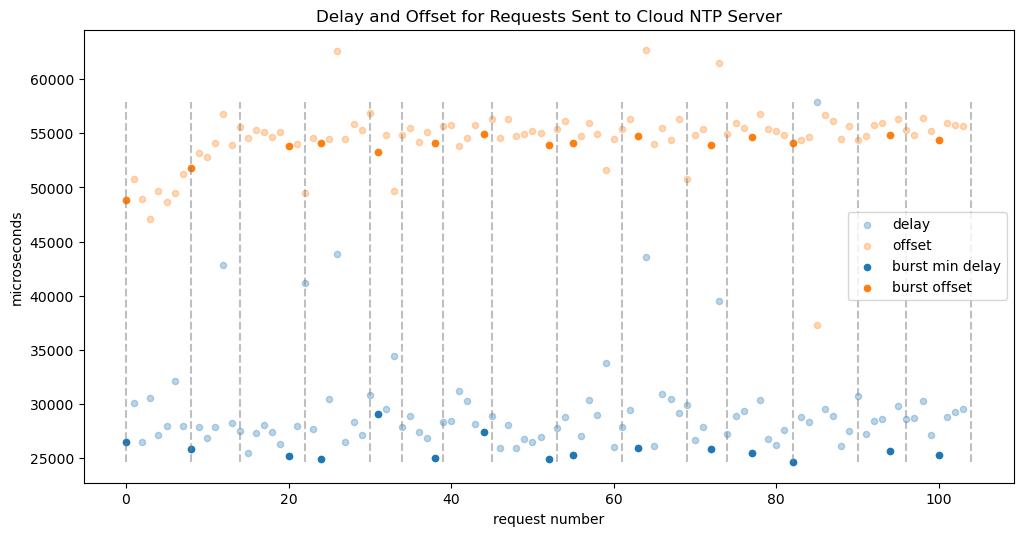

In [3]:
metadata = {
    'local_results.txt': {'outliers': 750, 'name': 'Local'},
    'nist_results.txt': {'outliers': 1_000_000, 'name': 'Public'},
    'cloud_results.txt': {'outliers': 100_000, 'name': 'Cloud'}
}

for filename in result_filenames:
    nist_delay, nist_offset, burst_divs = [], [], []
    min_nist_burst_delay, min_nist_burst_offset = [], []
    idx, min_delay_idx = 0, 0
    for burst in data[filename]['vi']:
        burst_divs.append(idx)
        min_delay, min_offset = 2_000_000, 2_000_000
        for uval in burst:
            if  uval.delay_usec < metadata[filename]['outliers'] and uval.offset_usec < metadata[filename]['outliers']:
                nist_delay.append(uval.delay_usec)
                nist_offset.append(uval.offset_usec)
                if uval.delay_usec < min_delay:
                    min_delay, min_offset = uval.delay_usec, uval.offset_usec
                    min_delay_idx = idx

                idx += 1
        min_nist_burst_delay.append((min_delay_idx, min_delay))
        min_nist_burst_offset.append((min_delay_idx, min_offset))

    burst_divs.append(idx)

    # for f in result_filenames:
    plt.figure(figsize=(12,6), dpi=100)
    plt.scatter(range(len(nist_delay)), nist_delay, s=20, c='tab:blue', label='delay', alpha=0.3)
    plt.scatter(range(len(nist_offset)), nist_offset, s=20, c='tab:orange', label='offset', alpha=0.3)
    plt.scatter([x for x, _ in min_nist_burst_delay],
                [delay for _, delay in min_nist_burst_delay],
                s=20, c='tab:blue', label='burst min delay')
    plt.scatter([x for x, _ in min_nist_burst_offset],
                [offset for _, offset in min_nist_burst_offset],
                s=20, c='tab:orange', label='burst offset')
    plt.vlines(burst_divs, ymin=min(nist_offset + nist_delay), ymax=max(nist_delay + nist_delay),
               colors='grey', linestyles='dashed', alpha=0.5)
    plt.ylabel('microseconds')
    plt.xlabel('request number')
    plt.title(f"Delay and Offset for Requests Sent to {metadata[filename]['name']} NTP Server")
    plt.legend()
    plt.show()

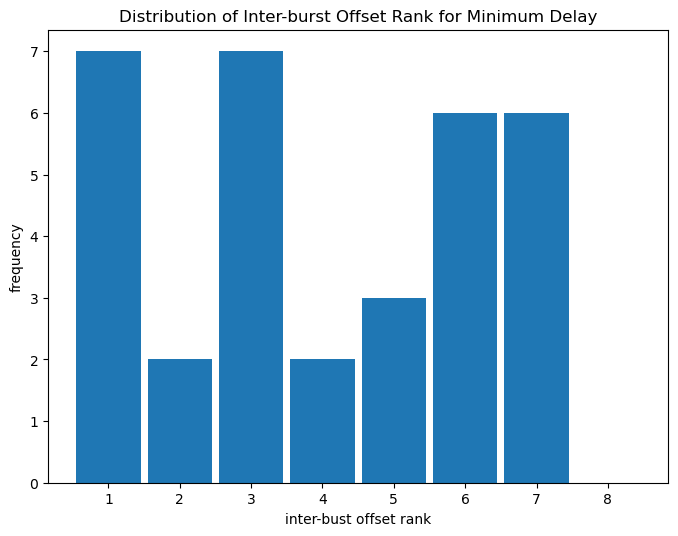

In [4]:

#     offset_rank = [burst.index(min(burst, key=lambda x: x.offset_usec))
#                    for burst.sort(key=lambda x: x.delay_usec) in data[f]['vi']]
offset_rank = []
for f in result_filenames:
    for burst in data[f]['vi']:

        burst.sort(key=lambda x: x.delay_usec)
        offset_idx = burst.index(min(burst, key=lambda x: x.offset_usec))
        offset_rank.append(offset_idx)
    
plt.figure(figsize=(8,6), dpi=100)
plt.hist(offset_rank, bins=range(1,10), align='left', rwidth=0.9)
plt.xlabel('inter-bust offset rank')
plt.ylabel('frequency')
plt.title("Distribution of Inter-burst Offset Rank for Minimum Delay")
plt.show()